
### The matrix multiplication tensor

The matrix multiplication tensor for $n x n$ matrices is

$$
MM^{abc}_{def} = \delta^a_e \delta^b_f \delta^c_d
$$

In [8]:
def MM_tensor(n): #BUT how does this related to x_shape and y_shape??
    # MM(a,b,c,d,e,f) = 1(ae)1(bf)1(cd)
    i, j, k = np.ogrid[:n, :n, :n]
    M = np.zeros((n,n,n,n,n,n))
#     print(j)
#     raise
    M[i, :, :, i, :, :] = 1  # 1 if a == e
    M[:, j, :, :, j, :] = 1  # 1 if b == f
    M[:, :, k, :, :, k] = 1  # 1 if c == d
    return M

# def MM_tensor(n): #BUT how does this related to x_shape and y_shape??
#     # MM(a,b,c,d,e,f) = 1(ae)1(bf)1(cd)
#     M = np.outer(np.outer(np.eye(n), np.eye(n)), np.eye(n))
#     return M

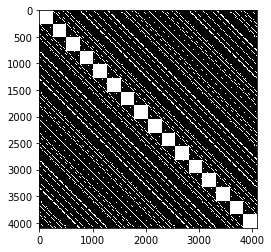

In [9]:
n = 16
M = MM_tensor(n)
plt.imshow(M.reshape((n**3,n**3)), cmap='gray')

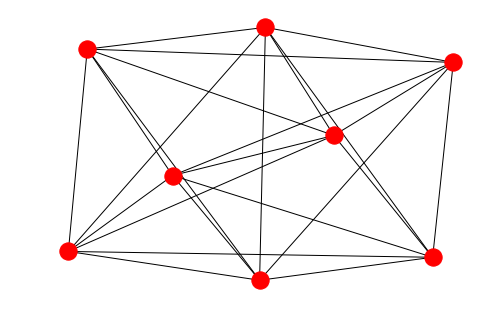

In [10]:
n = 2
m = MM_tensor(n)
m = m.reshape((n**3, -1))
# print(m)
g = nx.from_numpy_matrix(m)
g = nx.convert_node_labels_to_integers(g)
nx.draw(g, pos=nx.spring_layout(g))

In [11]:
np.rank(M)

/home/act65/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  """Entry point for launching an IPython kernel.


6

In [12]:
plt.figure()
plt.imshow(M[:,:,0,0,0,0].reshape((n,n)), cmap='gray')
plt.figure()
plt.imshow(M[:,0,:,0,0,0].reshape((n,n)), cmap='gray')
plt.figure()
plt.imshow(M[:,0,0,:,0,0].reshape((n,n)), cmap='gray')
plt.figure()
plt.imshow(M[:,0,0,0,:,0].reshape((n,n)), cmap='gray')
## WANT a way to visualise this thing!

ValueError: cannot reshape array of size 256 into shape (2,2)

>  However, de Groote [dG78] has shown that all 7-term decompositions of MM 2 are equivalent up to a change of basis, i.e., an instance of the GL(n)3 action (2)

ok. 
* wtf is the MM-tensor. 
* why does the MM-tensor rank have anything to do with the number of multiplications required?
* what is so special about GL(n)3? What has it got to do with MM?
* can we visualise the MM-tensor as a tensor network?

## Strassens algol for tensor contraction

Can we generalise strassen in a non-trivial way to tensors?

Currently (cite) best algol just reshapes tensor (in an intellgient way?) into a matrix and applies vanilla strassens algol. https://github.com/flame/tblis-strassen

WANT - if strassens does a 2d partition on matrices, can we formulate a nd partition and decompose that? So (2x2x2) x (2x2x2) is the base case for 3 dim tensors?!?

# Border rank!?

Approximate ranks on the 'border'?!?
[The border support rank of two-by-two matrix multiplication is seven](?)

## Learning strassens algol

http://jmlr.csail.mit.edu/papers/volume17/16-074/16-074.pdf

In [125]:

import autograd.numpy as np
import autograd.numpy.random as rnd
from autograd import grad
from autograd.misc.optimizers import adam

In [224]:
def tensor_representation(params, a, b):  
    # need a regulariser on the rank?!
    # reg = np.linalg.norm(mmt.reshape((n**3, n**3)), 'nuc')
    return np.einsum('ijklmn,bij,bkl->bmn', params['mmt'], a, b)

params = {
    'mmt': rnd.standard_normal([n]*6)
}
x = np.random.random((50, 2, 2))
tensor_representation(params, x, x).shape

(50, 2, 2)

In [225]:

# def decomposed_representation(params, a, b):  # this doesnt work. why?
#     mmt = np.einsum('ij,kl,mn->ikm', params['M_a'], params['M_b'], params['M_c'])
#     return np.einsum('ijk,j,k->i', mmt, a.flatten(), b.flatten()).reshape((n,n))

def net_constructor(params):
    return np.dot(np.concatenate([params['M_a'], 
                                  params['M_b']]), 
                  params['M_c'].T)

def net_representation(params, a, b):
    x = np.concatenate([a, b], axis=1)
    
    M = net_constructor(params)
    y = np.dot(x, M)
    
    return y.reshape((a.shape[0],a.shape[1]))

In [227]:

    
def mse(y, t):
    return np.mean(np.sum(np.square(y-t), axis=1)) 
def lr_decay(n, lr):
    return lr * 0.99 ** (n / 100)

    
def train(params, fn, n, iterations=10000, lr=0.01, batch_size=50):
    losses = []
    def loss_fn(params, t, a, b):
        y = fn(params, a, b)
        return mse(y, t)

    dL = grad(loss_fn)
    g_ = 0
    for i in range(iterations):
        # construct training data
        # could/should do in batches?!
        A = rnd.standard_normal((batch_size, n**2))
        B = rnd.standard_normal((batch_size, n**2))
        T = np.zeros((batch_size, n**2))
        
        for i in range(batch_size):
            T[i, :] = np.dot(A[i, :].reshape((n,n)), B[i, :].reshape((n,n))).flatten()
        
        grads = dL(params, T, A, B)

        for k, g in grads.items():
            g_ = 0.9*g_ + g 
            params[k] -= lr_decay(i, lr)*g_
            
        L = loss_fn(params, T, A, B)
        print('\rLoss: {:.3f}'.format(L), end='', flush=True)
        losses.append(L)

    return params, losses

In [232]:
n = 2
r = 6
params = {
    'M_a': rnd.standard_normal((n**2, r)),
    'M_b': rnd.standard_normal((n**2, r)),
    'M_c': rnd.standard_normal((n**2, r)),
}

params, losses = train(params, net_representation, n=n, iterations=1000, lr=0.001)

Loss: 8.804

In [241]:
losses = np.zeros((10, 1000))
for i, r in enumerate(range(2, 12)):
    params = {
        'M_a': rnd.standard_normal((n**2, r)),
        'M_b': rnd.standard_normal((n**2, r)),
        'M_c': rnd.standard_normal((n**2, r)),
    }

    params, L = train(params, net_representation, n=n, iterations=1000, lr=0.001)
    losses[i, :] = L

Loss: 8.130

(0, 20)

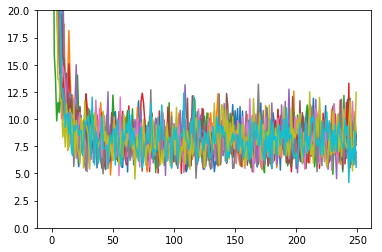

In [244]:
for i in range(10):
    plt.plot(losses[i, ::4])
    
plt.ylim(0, 20)

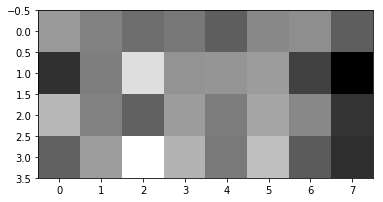

In [249]:
plt.imshow(net_constructor(params).reshape((n**2,n**3)), 
           cmap='gray', interpolation='nearest')

In [250]:
params = {
    'mmt': rnd.standard_normal([n]*6)
}

params = train(params, tensor_representation, n=n)

ValueError: ('Einstein sum subscript %s does not contain the correct number of indices for operand %d.', 'j', 1)

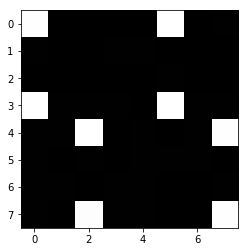

In [19]:
plt.imshow(params['mmt'].reshape((n**3,n**3)), cmap='gray', interpolation='nearest')

In [ ]:
# this is too expensive. 
# is there a better way to solve these?!?
ranks = []
for i in range(2, 10):
    params = {
        'mmt': rnd.standard_normal([i]*6)
    }

    params = train(params, tensor_representation, i, 0.001/i)
    ranks.append(np.linalg.matrix_rank(params['mmt'].reshape((i**3,i**3))))